# <strong> <font color=green> <center> <u>  Exploration et Traitement des données  </u>  </center> </font>  </strong>

---

   <p> Dans ce cette première partie consacrée à l'exploration et au traitement des données images, j'envisage dans un premier temps d'explorer l'objectif de la réduction des classes en 8 classes en me basant sur une approche qui repose sur la modification de fichier <strong> .json </strong>  

En effet les fichiers json qui sont fournis pour chaque images regroupent des informations sur : 
 * la taille des images; 
 * le nombre de segments présents sur l'image;
 * pour chaque segment/objets, les positions des polygones qui permettent de reconstruite le masque.
 
     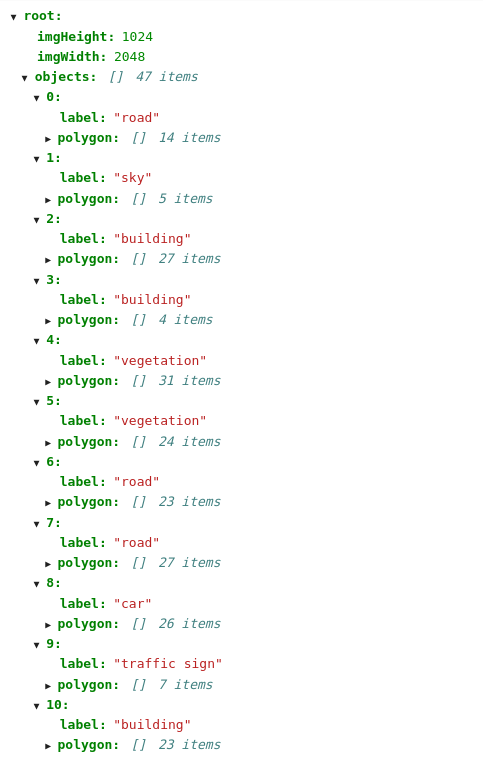      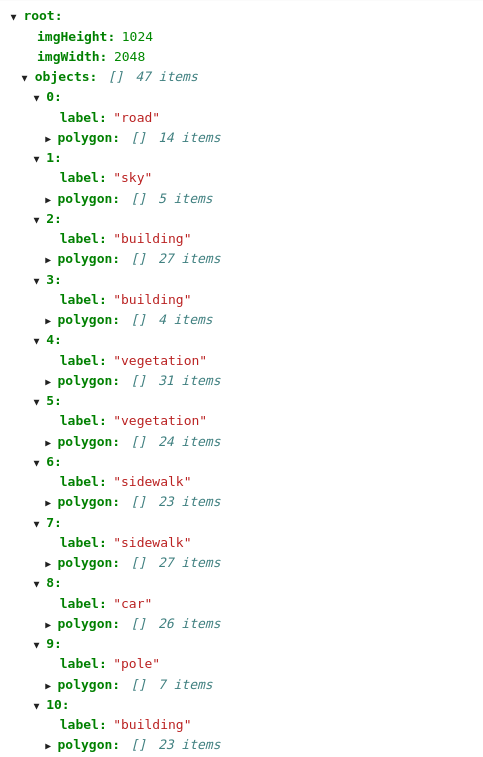
 

# <strong> I - Importation de modules

In [1]:
%pylab inline
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

########################################

import os
from tqdm import tqdm
import PIL
import json
import matplotlib.pyplot as plt
import seaborn as sns
import shutil
from glob import glob
import cv2

###########################################
try :
    import import_ipynb
except :
    !pip install import-ipynb
    import import_ipynb
from Brice_KENGNI_ZANGUIM_2_1_script_functions_25_10_2022 import *

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib
importing Jupyter notebook from Brice_KENGNI_ZANGUIM_2_1_script_functions_25_10_2022.ipynb


2022-11-02 19:40:47.639737: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-02 19:40:47.839100: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-11-02 19:40:48.705773: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2022-11-02 19:40:48.705894: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or 

# <strong> II - Traitement des images

In [2]:
faire_le_traitement_des_images = False

In [3]:
working_dir = os.getcwd()
working_dir

"/media/brice_kengni_zanguim/Samsung_T5/OC_Form/OC - P8 - Participez à la conception d'une voiture autonome"

In [20]:
if faire_le_traitement_des_images :
    ###################  Suppresion des fichiers Process déjà existant  ##################
    for data_kind in tqdm( [ "train", "val" ] ):
        for city in os.listdir("/".join([working_dir,"Images",data_kind])):
            city_path = "/".join([working_dir,"Images",data_kind, city])
            for image_name in os.listdir( city_path )  :
                if "process" in image_name  :
                    os.remove( "/".join([ city_path , image_name]) )
                    
    ##################   Effectuation du traitement  ##################
    for data_kind in [ "train", "val" ] :
        for city in os.listdir("/".join([working_dir,"Images",data_kind])):
            city_path = "/".join([working_dir,"Images",data_kind, city])
            for image_name in tqdm( os.listdir( city_path ) ) :
                if "leftImg8bit.png" in image_name  :
                    ##################  chargement des images ##################
                    image_0 = PIL.Image.open( "/".join([ city_path , image_name]) )
                    
                    ################## Process des images ##################
                    image = process_images(image_0, process_type="MEC", filter_size = 2 )
                    
                    ##################  Sauvegarde des images ##################
                    image.save( "/".join([ city_path , image_name[:-4]+"_process.png" ] ) )
    
    afficher_une_serie_d_images( image_0, image )

# <strong> III - Modification et sauvegarde des fichiers .json

### Le but de cette modification étant de classifier les 32 classes d'objects disponible dans le jeux de données en seulement 8 classes

In [5]:
modifier_les_fichiers_json = False

In [6]:
if modifier_les_fichiers_json :
    for data_kind in [ "train", "val" ] :
            for city in os.listdir("/".join([working_dir,"Images",data_kind])):
                city_path = "/".join([working_dir,"Images",data_kind, city])
                for json_name in tqdm( os.listdir( city_path ) ) :
                    if ".json" in json_name  :
                        json_file_path =  "/".join( [ city_path , json_name ] ) 
                        with open( json_file_path , 'r') as f :  # lecture du fichier Json
                            ################### Conversion en dictionnaire python  ##################
                            the_dict = json.load( f )  # the_dict = json.loads( f.read() )
                            
                            ###################  Update des valeurs des clés 'label' de chaque fichier Json  ##################
                            for pos, objets in enumerate( the_dict["objects"] ) :
                                label = objets["label"] 
                                if label in [ "sidewalk", "rail track", "parking" ] :
                                    the_dict["objects"][pos]["label"] = "road"
                                    
                                elif label in [ "rider" , 'persongroup'] :
                                    the_dict["objects"][pos]["label"] = "person"
                                    
                                elif label in [ "truck", "bus", "on rails", "caravan", "trailer", "train", "motorcycle", "bicycle", "license plate",
                                                'cargroup',  'bicyclegroup', 'motorcyclegroup', 'truckgroup', 'ridergroup'] :
                                    the_dict["objects"][pos]["label"] = "car"
                                    
                                elif label in [ "wall", "fence", "guard rail", "bridge", "tunnel" ] :
                                    the_dict["objects"][pos]["label"] = "building"
                                    
                                elif label in [ "pole", "polegroup", "traffic light" ] :
                                    the_dict["objects"][pos]["label"] = "traffic sign"
                                    
                                elif label in [ "terrain" ] :
                                    the_dict["objects"][pos]["label"] = "vegetation"
                                    
                                elif label in [ "ground", "static", "out of roi", "rectification border", "ego vehicle", "unlabeled" ] :
                                    the_dict["objects"][pos]["label"] = "dynamic"
                                    
                        with open( json_file_path , "w" ) as sf :
                            # Sauvegarde du fichier Json
                            json.dump( the_dict , sf )

# <strong> IV - Histrogramme de toutes les classes présentes dans tous les fichiers .json

###  L'idée étant de vérifier que le regroupement en 8 groupes d'objets a très bien été réalisé

In [7]:
count = {}

for data_kind in [ "train", "val" ] :
    for city in os.listdir("/".join([working_dir,"Images",data_kind])):
        city_path = "/".join([working_dir,"Images",data_kind, city])
        for json_name in  os.listdir( city_path )  :
            if ".json" in json_name  :
                json_file_path =  "/".join( [ city_path , json_name ] ) 
                with open( json_file_path , 'r') as f :  # lecture du fichier Json
                    # Conversion en dictionnaire python
                    the_dict = json.load( f )  # the_dict = json.loads( f.read() )

                    # Remplacement
                    for pos, objets in enumerate( the_dict["objects"] ) :
                        label = objets["label"] 

                        if label  in count.keys() :
                            count[label] += 1
                        else :
                            count[label] = 1

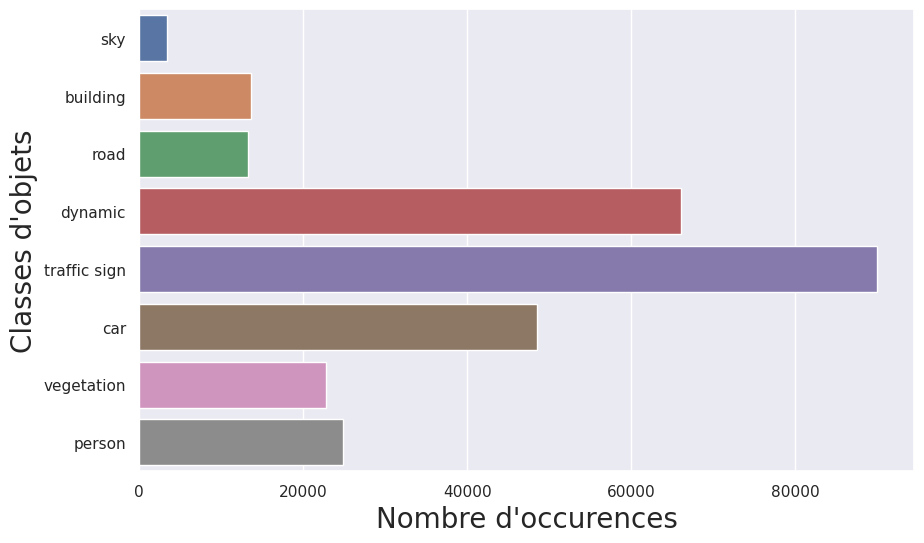

In [8]:
plt.figure(figsize=(10,6))
sns.barplot( pd.DataFrame({"x" : count.keys(), "y" : count.values() }) , y = "x",x = "y" , orient="h", )
plt.xlabel("Nombre d'occurences", size= 20)
plt.ylabel("Classes d'objets", size= 20)
plt.show()

### <strong> Sur l'hitogramme on remarque bien qu'on a uniquement 8 classes qui apparaissent dans le listing.

# <strong> V - Construction des nouvelles images colorées à partir des fichiers Json modifiés

### Pour utiliser le module `cityscapesscripts` il faut au préalable l'installer en utilisant la commande suivante : 

### <strong>  `python -m pip install cityscapesscripts`

- ###  <strong> importation du module necessaire. </strong>

In [9]:
try : 
    from cityscapesscripts.preparation import json2labelImg
except :
    ! python -m pip install cityscapesscripts
    from cityscapesscripts.preparation import json2labelImg

- ###  <strong> création de fichiers masque en niveau de gris ou en couleur </strong>

In [10]:
créer_les_nouvelles_images_colorées = False

In [11]:
if créer_les_nouvelles_images_colorées :
    for data_kind in [ "train", "val" ] :
        for city in os.listdir("/".join([working_dir,"Images",data_kind])):
            city_path = "/".join([working_dir,"Images",data_kind, city])
            for json_name in tqdm( os.listdir( city_path ) ) :
                if ".json" in json_name  :
                    ################### Chemin d'accès vers le fichier Json  ##################
                    json_file_path =  "/".join( [ city_path , json_name ] ) 

                    ###################   Création de l'image colorée  ##################
                    json2labelImg.json2labelImg( json_file_path , json_file_path[:-5]+"_new_colored_images_build.png", "trainIds") # "trainIds"
    
    ######################   Visualisation
    afficher_une_serie_d_images( PIL.Image.open(json_file_path), PIL.Image.open( json_file_path[:-5]+"_new_colored_images_build.png" ) )

- ###  <strong> Suppression de fichiers </strong>

In [12]:
supprimer_les_fichiers = False

In [13]:
if supprimer_les_fichiers :
    for data_kind in ["features_data", "train", "val" ] :
            for city in ["features_data","label_data"]:
                city_path = "/".join([working_dir,"Images",data_kind, city])
                for json_name in os.listdir( city_path ) :
                    if ".png.png" in json_name :
                        json_file_path =  "/".join( [ city_path , json_name ] ) 
                        os.remove(json_file_path)

# <strong> VI - Réorganisation des fichiers

### Je regroupe dans un même dossier :
 - Les fichier images à envoyer en entrée au modèle : Ce sont les images en couleur ayant été acquises par la céméra. Ils sont relocalisés dans le dossier `fetures_data`
 - Les fichiers images masque sur lesquelles chaque niveau de gris représente une segmentation de l'image d'origine : Ce ces les fichiers qui doivent être prédits par le modèle. Ils sont relocalisés dans le dossier `label_data`

- ###  <strong> déplacement de fichiers </strong>

In [14]:
relocaliser_les_fichiers = False

In [15]:
if relocaliser_les_fichiers :
    for data_kind in [ "train", "val" ] :
            for city in os.listdir("/".join([working_dir,"Images",data_kind])):
                if city not in ["features_data","label_data"] :
                    city_path = "/".join([working_dir,"Images",data_kind, city])
                    for json_name in tqdm( os.listdir( city_path ) ) :
                        if ".png" in json_name :
                            if "_process" in json_name  :
                                # Chemin d'accès vers le fichier Json
                                json_file_path =  "/".join( [ city_path , json_name ] ) 
                                # déplacement de fichiers
                                dir_path = city_path.split("/")[:-1] 
                                dir_path.append("features_data")
                                dir_path = "/".join( dir_path )
                                shutil.copy2(json_file_path, dir_path )
                                #os.system(f"cp {json_file_path} {dir_path}" )
                            elif "_build" in json_name  :
                                # Chemin d'accès vers le fichier Json
                                json_file_path =  "/".join( [ city_path , json_name ] ) 
                                # déplacement de fichiers
                                dir_path = city_path.split("/")[:-1] 
                                dir_path.append("label_data")
                                dir_path = "/".join( dir_path )
                                shutil.copy2(json_file_path, dir_path )
                                #os.system(f"cp {json_file_path} {dir_path}" )

- ###  <strong> reformatage des noms de fichiers dans les deux dossiers </strong>

les images associés doivent avoir le même nom dans les deux dossiers

In [16]:
renomer_les_fichiers = False

In [17]:
if renomer_les_fichiers :
    for data_kind in [ "train", "val" ] :
            for city in ["features_data","label_data"]:
                city_path = "/".join([working_dir,"Images",data_kind, city])
                for json_name in tqdm(os.listdir( city_path )) :
                    if ".png" in json_name :
                        # Chemin d'accès vers le fichier Json
                        json_file_path =  "/".join( [ city_path , json_name ] ) 
                        # nom du nouveau fichier
                        new_json_name = json_name.split(".")[0]
                        new_json_name = "_".join(json_name.split("_")[:3]) + ".png"
                        new_json_file_path =  "/".join( [ city_path , new_json_name ] )
                        os.rename(json_file_path, new_json_file_path )

- ###  <strong> résolution des images </strong>

In [18]:
modifier_la_resolution = False

In [19]:
if modifier_la_resolution :
    for data_kind in [ "train", "val" ] :
            for city in ["features_data","label_data"]:
                city_path = "/".join([working_dir,"Images",data_kind, city])
                for json_name in tqdm( os.listdir( city_path ) ) :
                    if ".png" in json_name :
                        # Chemin d'accès vers le fichier Json
                        json_file_path =  "/".join( [ city_path , json_name ] ) 
                        #  chargement des images
                        image = PIL.Image.open( json_file_path )
                        # Process des images
                        image = process_images(image, process_type="R", resolution =(512,256) )
                        # Sauvegarde des images
                        image.save( json_file_path )